Heretofore, all of our classification algorithms dealt with data that was labelled, and all the resulting algorithms were *supervised* (Note that PCA was unsupervised, but that was an algorithm for dimensionality reduction, not classification).  Here, we develop the entry-level member of a broad class of algorithms for fitting models that are not labelled, or so-called *unsupervised* classification algorithms.  To begin with, let's look at a new dataset, called the Old Faithful dataset which relates the occurrence time to the length of eruption for the Old Faithful geyser in Yellowstone National Park:
<img src="images/OldFaithful1948.jpg">
Since we'll be working with this dataset a little bit, it's available in the HW3 archive.  Let's load it into python. 


In [ ]:
from __future__ import print_function,division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)

# Note that this dataset is delimited by an arbitrary number of spaces, hence the r'\s*' regular expression
X = pd.read_csv('datasets/faithful.dat',delimiter=r'\s*',skiprows=25,engine='python').values

In [ ]:
plt.scatter(X[:,0],X[:,1])
plt.xlabel('Eruption Duration (minutes)')
plt.ylabel('Recurrence Interval (minutes)')
plt.show()

Notice the very different scales for each dimension.  K-means is highly susceptible to scale mismatch of this type because it relies on distance metrics.  We can eliminate this problem by substracting the mean and normalizing to unit variance.

In [ ]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X-X_mean)/X_std

plt.scatter(X[:,0],X[:,1])
plt.xlabel('Eruption Duration')
plt.ylabel('Recurrence Interval')
plt.show()

That's much better.  Now, let's run K-means on this dataset.  Let's begin by initializing the one-hot matrix of class membership.  Then, we can initialize the means:

In [ ]:
m = X.shape[0]                   # Number of data points
n = X.shape[1]
N = 2                            # Number of classes
y0 = np.random.randint(0,2,m)    # Initial class membership guess
Z = np.zeros((m,N)).astype(int)  # Create "one hot matrix"
for z,j in zip(Z,y0):
    z[j] = 1
    
# Initialize mu
Mu = np.vstack([X[Z[:,0]].mean(axis=0),X[Z[:,1]].mean(axis=0)])
print (Mu)    
    
# Plot initial guesses
plt.scatter(X[:,0],X[:,1],c=np.argmax(Z,axis=1))
plt.plot(Mu[:,0],Mu[:,1],'ro')

plt.xlabel('Eruption Duration')
plt.ylabel('Recurrence Interval')
plt.show()

Now we can implement a loop for K-means.  The first line computes the distance between every point and every mean.  The next three lines, constructs a new matrix $Z$ with a one in the column of the closest mean and a zero otherwise.  Finally, a new set of means are generated by taking the average of points assigned to that class mean.

In [ ]:
# Compute the misfit
def J(Z,Mu,X):
    JJ = 0
    for i in range(m):
        for k in range(N):
            JJ += Z[i,k]*np.sum((X[i]-Mu[k])**2)
    return JJ

# Compute distance from cluster means to points
def distances(X,Mu):
    D = np.zeros((m,N))
    for i in range(m):
        for k in range(N):
            D[i,k] = np.sum((X[i]-Mu[k])**2)
    return D

# Generate the one-hot matrix
def form_Z(X,Mu):
    Z = np.zeros((m,N))
    D = distances(X,Mu)
    for z,d in zip(Z,D):
        z[np.argmin(d)] = 1
    return Z

# Calculate the cluster means
def calc_mu(X,Z):
    Mu = np.zeros((N,n))
    for k in range(N):
        numerator = 0
        denominator = 0
        for i in range(m):
            numerator += Z[i,k]*X[i]
            denominator += Z[i,k]
        Mu[k] = numerator/denominator
    return Mu
        
# Calculate the initial misfit
Js = [J(Z,Mu,X)]

# Run five iterations of k-means
for i in range(5):
    # Form the one-hot class membership matrix
    Z = form_Z(X,Mu)
    # Calculate the cluster mean
    Mu = calc_mu(X,Z)
    
    # Compute the misfit (not necessary but useful for determining convergence)
    Js.append(J(Z,Mu,X))
      
plt.figure()
plt.scatter(X[:,0],X[:,1],c=np.argmax(Z,axis=1))
plt.plot(Mu[:,0],Mu[:,1],'ro')

plt.xlabel('Eruption Duration')
plt.ylabel('Recurrence Interval')
plt.show()
print (Mu)

We can also look at the misfit values as we update:

In [ ]:
print(Js)

K-means is quite efficient, and converges to the optimal value in three iterations for this problem.  However, it isn't really in line with our probabilistic approach for this class.  A good alternative is the Mixture of Gaussians model.  

Let's try MOG on this same dataset.  First, we'll re-import the data, this time without normalization because we'll be fitting a multi-variate normal which can account for different scalings between the feature values.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Note that this dataset is delimited by an arbitrary number of spaces, hence the r'\s*' regular expression
X = pd.read_csv('datasets/faithful.dat',delimiter=r'\s*',skiprows=25,engine='python').values

Next, we can initialize a few matrices.  As before, we need to initialize a few things, in this case, class means $\mathbf{\mu}_k$, class covariances $\Sigma_k$, the class priors $\pi_k$, and the responsibility matrix $\Gamma$

In [ ]:
from scipy.stats import multivariate_normal as mvn
import sys
sys.path.insert(0,'./libraries/')
from plot_ellipse import plot_ellipse

y0 = np.random.randint(0,2,m)    # Initial class membership guess
Z = np.zeros((m,N)).astype(int)  # Create "one hot matrix"
for z,j in zip(Z,y0):
    z[j] = 1
    
Gamma = Z
Pi = np.ones(N)/N
Sigma = np.ones((n,n,n))
Sigma[0,:,:] = np.eye(n)
Sigma[1,:,:] = np.eye(n)
    
# Initialize mu
Mu = np.vstack([X[Z[:,0]].mean(axis=0),X[Z[:,1]].mean(axis=0)])  

plt.figure()
plt.scatter(X[:,0],X[:,1],c=Gamma[:,0])
plot_ellipse(Mu[0],Sigma[0],alpha=0.3)
plot_ellipse(Mu[1],Sigma[1],alpha=0.3)
Mu = np.array(Mu)
plt.plot(Mu[:,0],Mu[:,1],'r.')

Now we can do a few iterations of EM

In [ ]:
# Compute the fractional class membership given parameters mu, sigma, pi (and the data)
def calc_Gamma(Mu,Sigma,Pi,X):
    Gamma = np.zeros((m,N))/N
    for k in range(N):
        pi = Pi[k]
        mu = Mu[k]
        sigma = Sigma[k]
        for p in range(m):
            Gamma[p,k] = pi*np.exp(-0.5*np.dot(X[p] - Mu[k],np.dot(np.linalg.inv(Sigma[k]),X[p]-Mu[k])))
    Gamma /= Gamma.sum(axis=1)[:,np.newaxis]  
    Nk = Gamma.sum(axis=0)
    return Gamma,Nk
       
# Compute the parameters given fractional class membership (and the data)
def calc_parameters(Gamma,Nk,X):
    for k in range(N):
        Mu[k] = 1./Nk[k]*np.sum(Gamma[:,k][:,np.newaxis]*X,axis=0)
        t = (X-Mu[k])[:,:,np.newaxis]
        that = (Gamma[:,k][:,np.newaxis]*(X-Mu[k]))[:,np.newaxis]
        tT = np.transpose(t,(0,2,1))
        Sigma[k]=1./Nk[k]*np.tensordot(that,tT,([0],[0])).squeeze()
        Pi[k] = Nk[k]/m
    return Mu,Sigma,Pi

# Perform 3 iterations of EM
for i in range(3):
    # Compute fractional class membership
    Gamma,Nk = calc_Gamma(Mu,Sigma,Pi,X)
    
    # Compute normal distribution parameters
    Mu,Sigma,Pi = calc_parameters(Gamma,Nk,X)
    print(Mu)

    # Plot resulting distributions
    plt.figure()
    plt.scatter(X[:,0],X[:,1],c=Gamma[:,0])
    plot_ellipse(Mu[0],Sigma[0],alpha=0.3)
    plot_ellipse(Mu[1],Sigma[1],alpha=0.3)
    Mu = np.array(Mu)
    plt.plot(Mu[:,0],Mu[:,1],'r.')

Expectation maximization, as it turns out, is very general, and can be applied any time where given the probability of class membership, we can compute the model parameters, AND given the model parameters, we can compute the probability of class membership.  One case where this is often true is with Hidden Markov Models.  For example, imagine a similar scenario to the homework: a game of dice at the Oxford.  Except that this time, we're trying to determine when the dealer was cheating *without ever having observed the states*.  

First let's have the dealer generate 1000 dice rolls according to the underlying Markov Model (remember, we don't actually have access to this information in a real situation.)

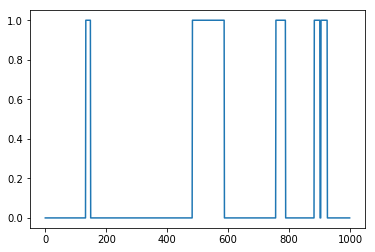

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(66)

states = [0,1]
observations = [0,1,2,3,4,5]

A = np.array([[0.99,0.01],[0.03,0.97]])
E = np.array([[1./6.]*6,[0.1,0.1,0.1,0.1,0.1,0.5]])
pi = np.array([1.,0.])


def emission(state):
    roll = np.random.choice(observations,p=E[state])
    return roll

def transition(state):
    return np.random.choice(states,p=A[state])

state = [0]
observation_list = [emission(state[0])]

for t in range(999):
    state.append(transition(state[-1]))
    observation_list.append(emission(state[-1]))

state = np.array(state)
observation_list = np.array(observation_list)

plt.plot(state)
plt.show()

Now, we'll implement Baum-Welch.  We first need a function that infers the state given the observations and the parameters.  The algorithm that we'll use is a slight variation on the forward algorithm called the forward-backwards algorithm which uses not only past information to infer the current state, but also future information.

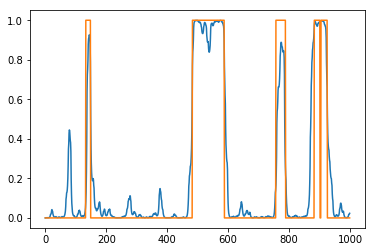

In [14]:
def forward_backwards(X,A,E,pi):
    
    m = len(X)

    def likelihood(x,z):
        return E[z,x]

    def prediction(z):
        return np.dot(z,A)

    def prior(z):
        return pi[z]

    x_0 = X[0]

    P = np.array([likelihood(x_0,0)*prior(0),likelihood(x_0,1)*prior(1)])
    P/=P.sum()

    likelihoods = np.array([[likelihood(o,z) for z in states] for o in X])

    alpha = np.zeros((1000,2))
    alpha[0] = P
    for t in range(1,m):
        P = alpha[t-1]
        prediction = np.dot(P,A)
        numerator = likelihoods[t]*prediction
        denominator = numerator.sum()
        alpha[t] = numerator/denominator

    T = m-1
    beta = np.zeros((m,2))
    beta[T] = 1.0
    for t in range(T-1,-1,-1):
        P = beta[t+1]
        numerator = np.dot(A,P*likelihoods[t+1])
        denominator = numerator.sum()
        beta[t] = numerator/denominator

    gamma = alpha*beta
    gamma = gamma/gamma.sum(axis=1)[:,np.newaxis]
    
    sigma = np.zeros((m,2,2))
    for t in range(m):
        for i in range(2):
            for j in range(2):
                try:    
                    sigma[t,i,j] = alpha[t,i]*A[i,j]*beta[t+1,j]*likelihoods[t+1,j]
                except IndexError:
                    sigma[t,i,j] = alpha[t,i]*A[i,j]
                 
        sigma[t,:,:] /= sigma[t,:,:].sum()

    return gamma, sigma

gamma, sigma = forward_backwards(observation_list,A,E,pi)
plt.plot(gamma[:,1])
plt.plot(state)
plt.show()

Next, we'll need a method for estimating parameter values ($A$ and $E$) given the observations.  This is just like the normal procedure, except that the counts are *weighted* by the state probabilities.

In [15]:
def compute_parameters(X,gamma,sigma):

    Njk = sigma.sum(axis=0)
    Nj = gamma.sum(axis=0)

    A = Njk/Nj[:,np.newaxis]
    E = np.zeros((2,6))
    for k in range(6):
        E[:,k] = gamma[X==k].sum(axis=0)/Nj

    return A,E
A,E = compute_parameters(observation_list,gamma,sigma)
print(A,E)

[[0.99189823 0.00810177]
 [0.02865397 0.97134603]] [[0.17893188 0.17285252 0.18888924 0.14792457 0.15361703 0.15778476]
 [0.09271692 0.10976875 0.10286846 0.11183642 0.1007136  0.48209585]]


Now we can write a simple loop back and forth between state prediction and parameter estimation.  Let's start with a bad guess for the transition matrix and emission probabilities:

97


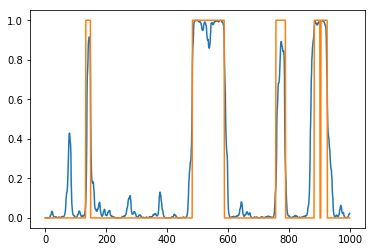

In [39]:
A = np.array([[0.8,0.2],[0.2,0.8]])
E = np.array([[1./6.]*6,[1./6.]*6])

gamma_previous = 0
t=0
abs_tol = 1e-7

while np.linalg.norm(gamma-gamma_previous)>abs_tol:
    gamma_previous = gamma
    gamma,sigma = forward_backwards(observation_list,A,E,pi)
    A,E = compute_parameters(observation_list,gamma,sigma)
    t += 1
    
print(t)

plt.plot(gamma[:,1])
plt.plot(state)
plt.show()


After 97 iterations, the algorithm reaches our tolerance threshold and terminates.  Let's look at the values of A and E that Baum-Welch predicts

In [40]:
print(A)
print(E)

[[0.99222443 0.00777557]
 [0.02716591 0.97283409]]
[[0.17932879 0.17256917 0.18920767 0.14763696 0.15349332 0.15776409]
 [0.09213981 0.11136089 0.10256506 0.11318791 0.10164887 0.47909746]]


Without ever having the knowledge of whether the dealer was cheating or not, we accurately computed the states, the transition probabilities, and the properties of the loaded dice!  Baum-Welch is pretty magical in this way.

The old faithful dataset is very easy to cluster because it's linearly separable.  Let's try a slightly more challenging example with the iris dataset.  

In [ ]:
from sklearn import datasets

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)

from plot_ellipse import plot_ellipse

data = datasets.load_iris()

Recall that the iris dataset is 4-dimensional, but for the purposes of visualization and simplicity, we will use a principal components analysis (which we will discuss week after next) to reduce the dimensionality to two.  You can think of this as taking combinations of the 4 initial variables to make 2 new variables that best explain the variability in the data.

In [ ]:
from sklearn import decomposition
pca = decomposition.PCA(0.95,whiten=False)
X = pca.fit_transform(data.data)

plt.scatter(X[:,0],X[:,1])
plt.show()

This time let's use the pre-fabricated GMM implementation in scikit learn.

In [ ]:
from sklearn import mixture
mix = mixture.GaussianMixture(n_components=3,max_iter=1000)
mix.fit(X)

We can use this fitted model to predict the fractional membership matrix 

In [ ]:
Z = mix.predict(X)
plt.scatter(X[:,0],X[:,1],c=Z)
for mu,sigma in zip(mix.means_,mix.covariances_):
    plot_ellipse(mu,sigma,alpha=0.3)
plt.show()
print (Gamma)


Not bad!  About the same accuracy as naive Bayes (which this algorithm is closely related to), but without the class labels.

But what if we didn't know the number of classes *a priori*?  This turns out to be one of the central questions of unsupervised learning, and there are many possible answers.  One of the easiest however is to fit the model several times using different numbers of classes, and to evaluate a model selection criterion such as BIC (Bayesian Information Criterion).

Bayesian Information Criterion is formally defined as
$$
BIC = \ln (m) k - 2 \ln (L),
$$
where $m$ is the number of data points, $k$ the number of model parameters, and $L$ the likelihood function.  The best choice of model minimizes the BIC.  Note that the BIC goes up when the number of parameters is increased, and goes down as the log likelihood increases.  Thus the BIC penalizes both data misfit and having a complex model.  Note that, in general, as the sample size increases, the likelihood goes down just because there are more observations for which misfit is added to the objective function.  This is why the $\ln (m)$ is there: we don't want to penalize having more data, it's just there in order to scale the parameter penalty. 

With BIC in hand, we can fit multiple models, evaluate the BIC, and then choose the model for which BIC is minimized.

In [ ]:
plt.figure()
BICs = []
for n_clusters in range(1,7):
    mix = mixture.GaussianMixture(n_components=n_clusters,max_iter=1000)
    mix.fit(X)
    BICs.append(mix.bic(X))

plt.plot(range(1,7),BICs)
plt.show()

Note that the minimum of BIC suggests only two clusters!  Maybe this isn't so surprising.  Looking at our data again, without class labels it's not very easy to see the divide between two of the classes.

In [ ]:
plt.scatter(X[:,0],X[:,1])
plt.show()

In [ ]:
mix = mixture.GaussianMixture(n_components=2,max_iter=1000)
mix.fit(X)

y_pred = mix.predict(X)
plt.scatter(X[:,0],X[:,1],c=y_pred)
for mu,sigma in zip(mix.means_,mix.covariances_):
    plot_ellipse(mu,sigma,alpha=0.3)
plt.show()

This case is a little bit challenging.  To see how BIC can help pick the number of classes, let's make up some data that is more easily separated.

In [ ]:
sigma = 0.1
means = np.array([[0,0],[0,1],[1,0],[1,1]])
random_centers = np.random.randint(0,4,200)
X = means[random_centers] + sigma*np.random.randn(200,2)
plt.scatter(X[:,0],X[:,1])
plt.show()

Obviously, we have four distinct clusters.  Let's loop over $k$ as before, and compute the BIC for each.

In [ ]:
plt.figure()
BICs = []
for n_clusters in range(1,10):
    mix = mixture.GaussianMixture(n_components=n_clusters,max_iter=1000)
    mix.fit(X)
    BICs.append(mix.bic(X))
plt.plot(range(1,10),BICs)
plt.show()

Clearly, we have a minimum at $k=4$, so BIC has picked out the correct number of clusters to fit.

What happens if the data becomes a little bit more ambiguous?

In [ ]:
sigma = 0.3
means = np.array([[0,0],[0,1],[1,0],[1,1]])
random_centers = np.random.randint(0,4,200)
X = means[random_centers] + sigma*np.random.randn(200,2)
plt.scatter(X[:,0],X[:,1])
plt.show()

In [ ]:
plt.figure()
BICs = []
for n_clusters in range(1,10):
    mix = mixture.GaussianMixture(n_components=n_clusters,max_iter=1000)
    mix.fit(X)
    BICs.append(mix.bic(X))
plt.plot(range(1,10),BICs)
plt.show()

Clearly, there isn't enough division between classes to infer that there should be 4 clusters.  Instead BIC implies that we'd be better off combining two of the clusters:

In [ ]:
plt.figure()
n_clusters = np.argmin(BICs)+1
mix = mixture.GaussianMixture(n_components=n_clusters,max_iter=1000)
mix.fit(X)
y_pred = mix.predict(X)

plt.scatter(X[:,0],X[:,1],c=y_pred)
for mu,sigma in zip(mix.means_,mix.covariances_):
    plot_ellipse(mu,sigma,alpha=0.3)
    
plt.show()